# Simulate PTA with PTA-replicator and Enterprise

In [1]:
from pta_replicator_main.pta_replicator.simulate import load_from_directories
from pta_replicator_main.pta_replicator.simulate import make_ideal
from pta_replicator_main.pta_replicator.white_noise import add_measurement_noise
from pta_replicator_main.pta_replicator.red_noise import add_red_noise, add_gwb
from pta_replicator_main.pta_replicator.deterministic import add_cgw

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import selections
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals.utils import hd_orf
from enterprise.signals import utils
from enterprise_extensions.deterministic import cw_block_circ

import pickle
import dill
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from random import sample, seed

import params_injected
from pulsar_phase import get_psr_phase

%load_ext autoreload
%autoreload 2

## Simulate pulsars

In [2]:
pardir = 'partim/par'
timdir = 'partim/tim'
num_psrs = params_injected.num_psrs
# psrs = load_from_directories(pardir, timdir, num_psrs=num_psrs)
psrs_full = load_from_directories(pardir, timdir, num_psrs=50)
seed(0)
psrs = sample(psrs_full, k=num_psrs)

2025-08-12 17:08:03.880 | DEBUG    | pint.toa:__init__:1358 - No pulse number flags found in the TOAs
2025-08-12 17:08:03.881 | DEBUG    | pint.toa:apply_clock_corrections:2200 - Applying clock corrections (include_gps = True, include_bipm = True)
2025-08-12 17:08:03.889 | INFO     | pint.observatory:gps_correction:210 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-12 17:08:03.889 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2025-08-12 17:08:03.892 | INFO     | pint.observatory.global_clock_corrections:get_file:128 - File index.txt to be downloaded due to download policy if_expired: https://raw.githubusercontent.com/ipta/pulsar-clock-corrections/main/index.txt
2025-08-12 17:08:04.148 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-08-12 17:08:04.151 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:456

In [3]:
# store injected parameters
x_inj = {}

# add signals and noise
psr_phases = np.zeros(num_psrs)
for ii, psr in enumerate(psrs):

    ## make ideal
    make_ideal(psr)

    # add efacs
    ## if you use flags, the flags and efac and equad values all need to have the same number of elements
    add_measurement_noise(psr,
                          efac=params_injected.efac_inj, 
                          seed=params_injected.efac_seed + ii)

    ## add red noise
    if params_injected.rn_model:
        add_red_noise(psr,
                      log10_amplitude=params_injected.RN_logamps_inj[ii],
                      spectral_index=params_injected.RN_gammas_inj[ii],
                      components=params_injected.num_modes,
                      seed=params_injected.RN_seed + ii)
        x_inj[f'{psr.name}_red_noise_log10_A'] = params_injected.RN_logamps_inj[ii]
        x_inj[f'{psr.name}_red_noise_gamma'] = params_injected.RN_gammas_inj[ii]
    
    ## add continuous wave
    if params_injected.cw_model:
        ent_psr = psr.to_enterprise()
        psr_dist = ent_psr.pdist[0]
        psr_phase = get_psr_phase(params_injected.CW_params_inj, ent_psr.pos, psr_dist)
        psr_phases[ii] = psr_phase
        psr_params = np.array([psr_dist, psr_phase])
        add_cgw(psr, params_injected.CW_params_inj, psr_params, ent_psr.toas, ent_psr.pos)
        x_inj[f'{psr.name}_cw_p_dist'] = psr_dist
        x_inj[f'{psr.name}_cw_p_phase'] = psr_phase 

    print(ii, psr.name)

# add common CW parameters
if params_injected.cw_model:
    x_inj['cw_cosinc'] = params_injected.cosinc_inj
    x_inj['cw_costheta'] = params_injected.costheta_inj
    x_inj['cw_log10_Mc'] = params_injected.log10_mc_inj
    x_inj['cw_log10_dL'] = params_injected.log10_dist_inj
    x_inj['cw_log10_fgw'] = params_injected.log10_fgw_inj
    x_inj['cw_phase0'] = params_injected.phase0_inj
    x_inj['cw_phi'] = params_injected.gwphi_inj
    x_inj['cw_psi'] = params_injected.psi_inj

2025-08-12 17:08:15.065 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-12 17:08:15.066 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-12 17:08:15.066 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-12 17:08:15.067 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-12 17:08:15.082 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-12 17:08:15.083 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-12 17:08:15.084 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-12 17:08:15.084 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-12 17:08:15.084 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

0 J1312+0051


2025-08-12 17:08:16.393 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-12 17:08:16.393 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-12 17:08:16.394 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-12 17:08:16.394 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-12 17:08:16.411 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-12 17:08:16.411 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-12 17:08:16.412 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-12 17:08:16.412 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-12 17:08:16.412 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

1 J1909-3744


2025-08-12 17:08:17.366 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-12 17:08:17.367 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-12 17:08:17.367 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-12 17:08:17.368 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-12 17:08:17.368 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. Removing...
2025-08-12 17:08:17.369 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_saturn_pos already exists. Removing...
2025-08-12 17:08:17.369 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_venus_pos already exists. Removing...
2025-08-12 17:08:17.370 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_uranus_pos already exists. Removing...
2025-08-12 17:08:17.370 | DEBUG    | pin

2 J1455-3330


2025-08-12 17:08:18.469 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409705e+09  1.34555717e+11  5.83294451e+10] m
2025-08-12 17:08:18.470 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:18.471 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:18.472 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:18.473 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:18.474 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:18.475 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:18.476 | INFO     | pint.sol

3 B1953+29


2025-08-12 17:08:19.630 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409709e+09  1.34555717e+11  5.83294451e+10] m
2025-08-12 17:08:19.631 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:19.633 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:19.635 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:19.636 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:19.637 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:19.638 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-12 17:08:19.639 | INFO     | pint.sol

4 J0709+0458


In [4]:
if params_injected.gwb_model:
        add_gwb(psrs,
                log10_amplitude=params_injected.GWB_logamp_inj,
                spectral_index=params_injected.GWB_gamma_inj,
                seed=params_injected.GWB_seed)
        x_inj['log10_A_gw'] = params_injected.GWB_logamp_inj
        x_inj['gamma_gw'] = params_injected.GWB_gamma_inj

In [5]:
# fit timing model
for psr in psrs:
    print(psr.name)
    psr.fit()

2025-08-12 17:08:20.497 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1312+0051


2025-08-12 17:08:21.407 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.001280939005913806
2025-08-12 17:08:21.811 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1909-3744


2025-08-12 17:08:22.704 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0008402809449439275
2025-08-12 17:08:22.764 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1455-3330


2025-08-12 17:08:23.670 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0005580128583965449
2025-08-12 17:08:24.073 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


B1953+29


2025-08-12 17:08:24.967 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.002743658556896733
2025-08-12 17:08:25.375 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0709+0458


2025-08-12 17:08:26.280 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0003319757518168154


J1312+0051


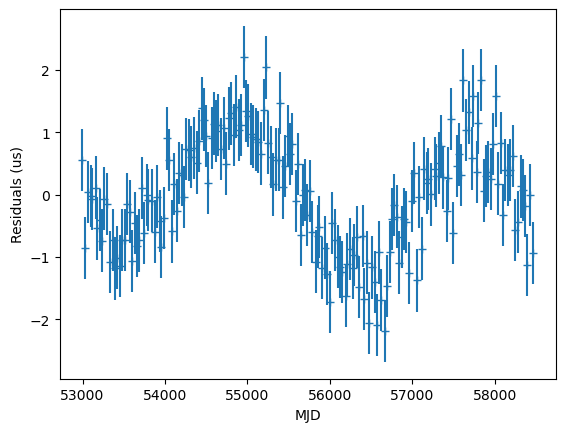

J1909-3744


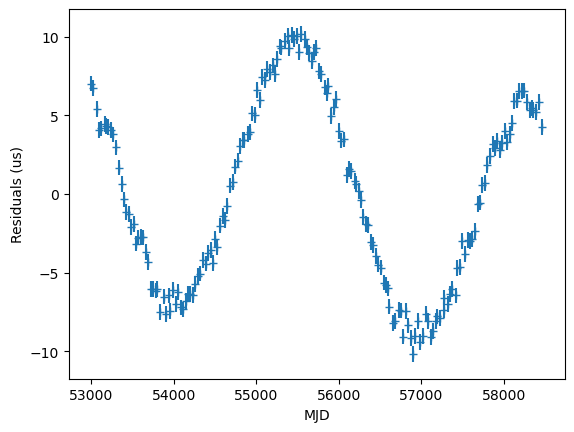

J1455-3330


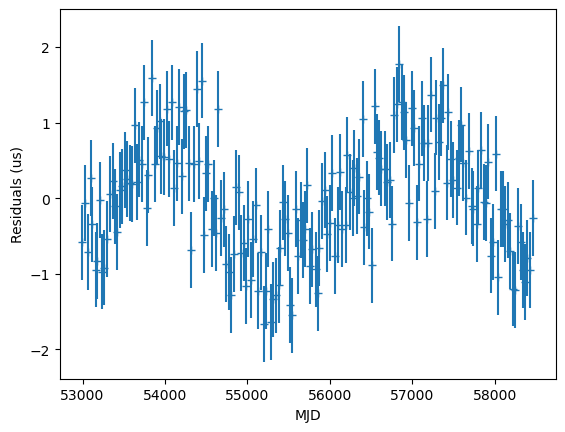

B1953+29


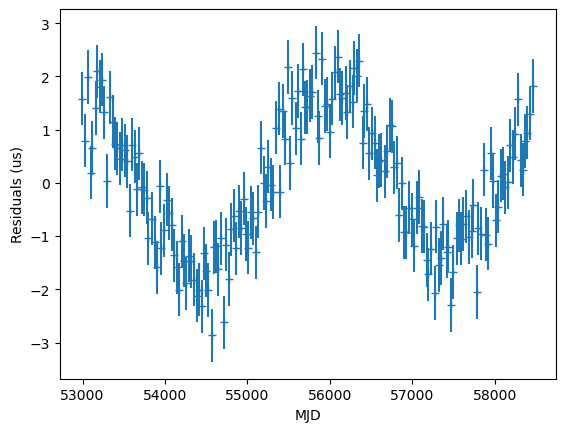

J0709+0458


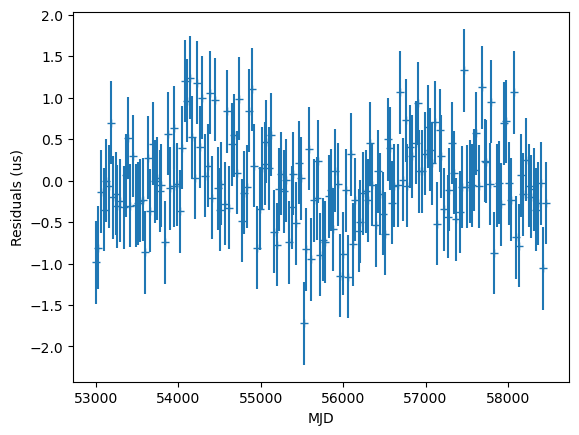

In [6]:
for psr in psrs:
    print(psr.name)
    plt.errorbar(
        psr.toas.get_mjds(),
        psr.residuals.time_resids.to_value("us"),
        psr.residuals.get_data_error().to_value("us"),
        marker="+",
        ls="",
    )
    plt.xlabel("MJD")
    plt.ylabel("Residuals (us)")
    plt.show()

In [7]:
# convert to enterprise type pulsars
ent_psrs = []
for psr in psrs:
    ent_psrs.append(psr.to_enterprise())

2025-08-12 17:08:27.144 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-12 17:08:27.651 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-12 17:08:28.155 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-12 17:08:28.658 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-12 17:08:29.162 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.


In [8]:
# save Enterprise pulsar objects
with open('data/enterprise_pulsars.pkl', 'wb') as f:
    pickle.dump(ent_psrs, f)

In [9]:
for psr in ent_psrs:
    print(psr.pdist)

(1.0, 0.2)
(1.26, 0.03)
(0.74, 0.15)
(5.39, 1.1)
(1.0, 0.2)


## Make PTA

In [10]:
# use built in backend selection
backend = selections.Selection(selections.by_backend)

# EFAC parameter
if params_injected.wn_model:
    efac_param = parameter.Uniform(0.5, 3.0)
else:
    efac_param = params_injected.efac_inj

# make white noise
wn = white_signals.MeasurementNoise(efac=efac_param,
                                    log10_t2equad=-1000, 
                                    selection=backend)

In [11]:
# red noise
if params_injected.rn_model:
    logamp_param = parameter.Uniform(-18., -11.)
    gamma_param = parameter.Uniform(1., 7.)

    # get power law in prior
    powlaw = gp_priors.powerlaw(log10_A=logamp_param, gamma=gamma_param)

    # make red noise
    rn = gp_signals.FourierBasisGP(spectrum=powlaw, components=params_injected.num_modes)

In [12]:
# GWB
if params_injected.gwb_model:
    log10_A_gw = parameter.Uniform(-18., -11.)('log10_A_gw')
    gamma_gw = parameter.Uniform(1., 7.)('gamma_gw')
    cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
    gw = gp_signals.FourierBasisCommonGP(spectrum=cpl, orf=hd_orf(),
                                         components=params_injected.num_modes, name='gw')

In [13]:
# make CW signal
if params_injected.cw_model:
    cw = cw_block_circ(dist_prior='log-uniform', psrTerm=True)

In [14]:
# make timing model
tm = gp_signals.TimingModel(use_svd=True)

In [15]:
# make model and PTA object
model = tm + wn
if params_injected.rn_model:
    model += rn
if params_injected.gwb_model:
    model += gw
if params_injected.cw_model:
    model += cw
    
pta = signal_base.PTA([model(psr) for psr in ent_psrs])

In [16]:
# save PTA object
with open('data/pta.pkl', 'wb') as f:
    dill.dump(pta, f)

print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1312+0051_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1312+0051_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J1312+0051_cw                            CWSignal                       10                  

params:
cw_costheta:Uniform(pmin=-1, pmax=1)                                                      
cw_phi:Uniform(pmin=0, pmax=6.283185307179586)                                            
cw_cosinc:Uniform(pmin=-1.0, pmax=1.0)                                                    
cw_log10_Mc:Uniform(pmin=6.0, pmax=10.0)                                                  
cw_log10_fgw:Unifo

In [17]:
# save data
Fs = np.array([basis[:, 8:] for basis in pta.get_basis()])
Ms = np.array([ent_psr.Mmat for ent_psr in ent_psrs])
Ns = np.array([np.diag(ent_psr.toaerrs**2.) for ent_psr in ent_psrs])
toas = np.array([ent_psr.toas for ent_psr in ent_psrs])
residuals = np.array([ent_psr.residuals for ent_psr in ent_psrs])
psr_pos = np.array([ent_psr.pos for ent_psr in ent_psrs])
psr_names = np.array([ent_psr.name for ent_psr in ent_psrs])
psr_dists = np.array([[psr.pdist[0], psr.pdist[1]] for psr in ent_psrs]).T

# save data in dictionary
data_dict = {}
data_dict['Fs'] = Fs
data_dict['Ms'] = Ms
data_dict['Ns'] = Ns
data_dict['toas'] = toas
data_dict['residuals'] = residuals
data_dict['psr_pos'] = psr_pos
data_dict['psr_names'] = psr_names
data_dict['psr_dists'] = psr_dists
data_dict['psr_phases'] = psr_phases
data_dict['x_inj'] = x_inj
np.savez_compressed('data/data_dict.npz', **data_dict)

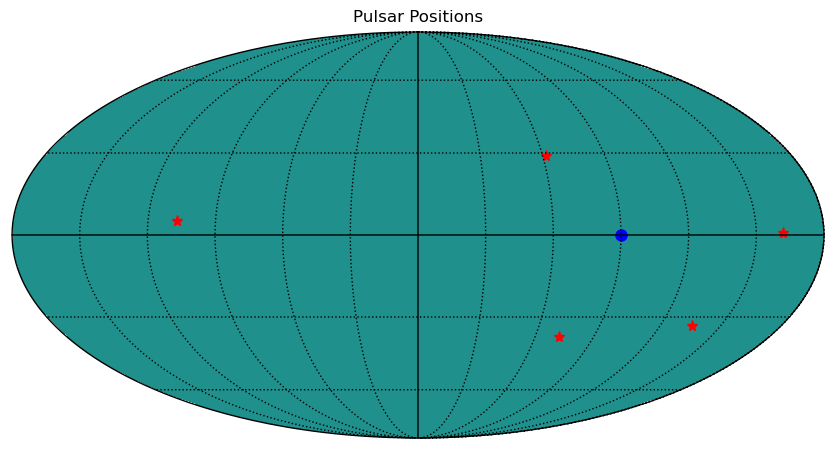

In [18]:
# plot pulsar positions
theta_psr = np.arccos(psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.arctan2(psr_pos[:, 1], psr_pos[:, 0])  # atan2(y, x)
phi_psr = np.mod(phi_psr, 2 * np.pi)


# Convert to HEALPix map
nside = 64
npix = hp.nside2npix(nside)

# Plot
hp.mollview(np.zeros(hp.nside2npix(64)), title="Pulsar Positions", cbar=False)
hp.projplot(theta_psr, phi_psr, 'r*', markersize=8)
hp.projplot(params_injected.gwtheta_inj, params_injected.gwphi_inj, 'bo', markersize=8)
hp.graticule()
plt.show()